In [3]:
from numpy import array
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import seaborn as s
import matplotlib.pyplot as plt

In [1]:

from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, GlobalMaxPooling1D, Embedding, LSTM
from sklearn.model_selection import train_test_split
import seaborn as s


In [4]:
movie_reviews = pd.read_csv("IMDB Dataset.csv")

In [5]:

movie_reviews.isnull().values.any()


False

In [6]:

movie_reviews.shape

(50000, 2)

In [7]:

movie_reviews.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:

movie_reviews["review"][4]

'Petter Mattei\'s "Love in the Time of Money" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success do to people in the different situations we encounter. <br /><br />This being a variation on the Arthur Schnitzler\'s play about the same theme, the director transfers the action to the present time New York where all these different characters meet and connect. Each one is connected in one way, or another to the next person, but no one seems to know the previous point of contact. Stylishly, the film has a sophisticated luxurious look. We are taken to see how these people live and the world they live in their own habitat.<br /><br />The only thing one gets out of all these souls in the picture is the different stages of loneliness each one inhabits. A big city is not exactly the best place in which human relations find sincere fulfillment, as one discerns is the case wit

'Petter Mattei Love in the Time of Money is visually stunning film to watch Mr Mattei offers us vivid portrait about human relations This is movie that seems to be telling us what money power and success do to people in the different situations we encounter This being variation on the Arthur Schnitzler play about the same theme the director transfers the action to the present time New York where all these different characters meet and connect Each one is connected in one way or another to the next person but no one seems to know the previous point of contact Stylishly the film has sophisticated luxurious look We are taken to see how these people live and the world they live in their own habitat The only thing one gets out of all these souls in the picture is the different stages of loneliness each one inhabits big city is not exactly the best place in which human relations find sincere fulfillment as one discerns is the case with most of the people we encounter The acting is good under

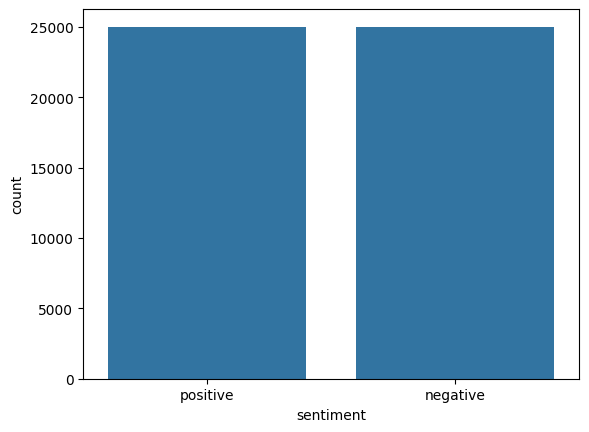

In [9]:


s.countplot(x='sentiment', data=movie_reviews)
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

review = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    review.append(preprocess_text(sen))

review[4]

In [10]:
from numpy import array
from numpy import asarray
from numpy import zeros

In [11]:
from keras.layers import LSTM

In [12]:

converted = movie_reviews['sentiment']

converted = np.array(list(map(lambda x: 1 if x=="positive" else 0, converted)))


In [15]:
review_train, review_test, converted_train, converted_test = train_test_split(review, converted, test_size=0.20, random_state=42)

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(review_train)

review_train = tokenizer.texts_to_sequences(review_train)
review_test = tokenizer.texts_to_sequences(review_test)

vocab_size = len(tokenizer.word_index) + 1
maxlen = 100
review_train = pad_sequences(review_train, padding='post', maxlen=maxlen)
review_test = pad_sequences(review_test, padding='post', maxlen=maxlen)

embeddings_dictionary = dict()
glove_file = open('glove.6B/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [16]:

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector


model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(review_train, converted_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(review_test, converted_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

c:\Users\BoDa\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     9,254,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,254,700 (35.30 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,254,700 (35.30 MB)

Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 93ms/step - acc: 0.6421 - loss: 0.6234 - val_acc: 0.7632 - val_loss: 0.5130
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - acc: 0.7787 - loss: 0.4746 - val_acc: 0.8043 - val_loss: 0.4461
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - acc: 0.8086 - loss: 0.4238 - val_acc: 0.8328 - val_loss: 0.3772
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 91ms/step - acc: 0.8293 - loss: 0.3756 - val_acc: 0.8338 - val_loss: 0.3719
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - acc: 0.8441 - loss: 0.3533 - val_acc: 0.8468 - val_loss: 0.3461
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 24s 96ms/step - acc: 0.8559 - loss: 0.3280 - val_acc: 0.8501 - val_loss: 0.3417
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - acc: 0.8457 - loss: 0.3449
Test Score: 0.3397916555404663
Test Accuracy: 0.8489999771118164


What happened What we have here is basically solid and plausible premise and with decent and talented cast but somewhere the movie loses it Actually it never really got going There was little excitement when we find out that Angie is not really pregnant then find out that she is after all but that was it Steve Martin who is very talented person and usually brings lot to movie was dreadful and his entire character was not even close to being important to this movie other than to make it longer really would have liked to see more interactions between the main characters Kate and Angie and maybe try not for pure comedy which unfortunately it was not but maybe drama with comedic elements think if the movie did this it could have been very funny since both actresses are quite funny in their own ways and sitting here can think of numerous scenarios that would have been riot 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


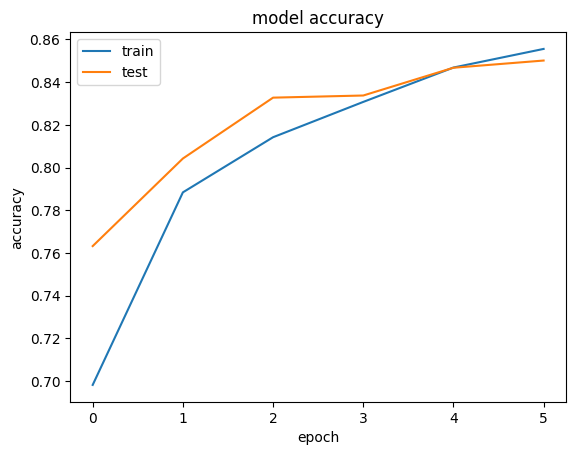

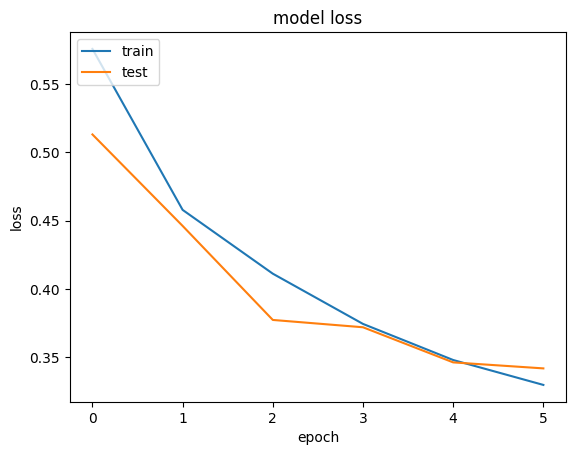

In [17]:
instance = review[60]
print(instance)

instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()